# Case Study: COVID-19

Complementary to the diversified and comprehensive models being built to understand the development of the coronavirus, I will apply and analyze a time-series model to the population growth of COVID-19 hospitalizations. 

A common task with time-series modeling is smoothing; a common technique used to remove noise in data. In this context, our goal is to understand if there is a smooth, underlying growth process of COVID-19 cases given noisy count data.

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import geopandas as gpd #conda activate geo-env
import numpy.random as rnd
import scipy.stats as sstats
import statsmodels.api as sm
%matplotlib inline

In [66]:
# import pandas as pd
# hosp = pd.read_csv('COVID19_line_list_data.csv')
# hosp_counts = np.array(hosp.groupby('hosp_visit_date').sum()['case_in_country'].tolist())

In [131]:
# covid = pd.read_csv('us-counties.csv')
# covid = covid.groupby('fips').sum().reset_index()
# covid

In [130]:
# #interactive heat map

# import json
# from urllib.request import urlopen
# import plotly.graph_objs as go

# token = 'pk.eyJ1IjoiYW1hbmRyZWxsIiwiYSI6ImNrOG94cDdocDE5bXkzbmt6NnE3Y2lpem8ifQ.2a8wjkVA88d5jc080CxSqw' # you will need your own token

# with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#     counties = json.load(response)

# import plotly.express as px

# fig = go.Figure(go.Choroplethmapbox(geojson=counties, locations=covid.fips, z=covid.cases,
#                                     #text=covid.county,
#                                     colorscale='blues', zmin=0, zmax=12, marker_line_width=0))
# fig.update_layout(mapbox_style="light", mapbox_accesstoken=token,
#                   mapbox_zoom=3, mapbox_center = {"lat": 37.0902, "lon": -95.7129})
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [68]:
hospitalizations = pd.read_csv('COVID19_line_list_data.csv')
hospitalizations.head(1)

,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,"Shenzhen, Guangdong",China,male,66.0,01/03/20,...,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
#get total hospitalizations data based on each day
hosps_counts = np.array(hospitalizations.groupby('hosp_visit_date').sum()['case_in_country'].tolist())

Let $X_t$ be the observed number of hospitalizations due to COVID-19 on day $t$. $X_t$ is a noisy, random subset of cases that lead to hospitalizations. We also include in our model latent variables $Z_t$,representing the expected number of hospitalizations on day $t$. In this study, my goal will be to approximate a relationship between $X_t$ and $t$ by leveraging a Generalized Linear Model [http://cs229.stanford.edu/notes/cs229-notes1.pdf]. In a time series, we observe some output variable $X_t$, and we want to model the evolution of $X_t$ as time $t$ grows. First, we will observe some examples $X_0,X_1...,X_T$. Our goal is to use our observed data to model $X_t$ as a random variable that depends on $t$, and then potentially predict (or forecast) the values $X_t$ for unobserved $t$ in the future. In a generalized linear model, we can model $X$  as any other exponential family distribution whose mean is any invertible function  $g$  of a linear function of  $T$. Once we've specified the output distribution and link function, the goal is to find the maximum likelihood estimate the linear parameters  $\beta$. Once we have an estimate of the parameters  $\beta$, we can use this estimate to predict the values of $T$ for different inputs $T$.


We assume that $X_t$ has mean $Z_t$.

Epidemiology [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5348083/]  tells  us  that  in  some  settings, exponential growth for $Z_t$ is reasonable: 

$$Z_{t} = (1+r)Z_{t-1}$$ for some unknown growth rate $r$. Unrolling the recursion, we have $$Z_{t} = (1+r)^tZ_0$$


In order to leverage a Generalized Linear model, we need to specify a link function and output distribution. Disregarding a monotonous mathematical proof, our link function is: $$log(\mathbb{E}(T))=log(Z_0) + log(1+r)T$$.

Intuitively, our parameters we want to estimate are $\beta = [\beta_0, \beta_1] = [log(Z_0), log(1+r)]$ In this conetxt, a natural choice for our output distribution is Poisson: $$X_t \sim Poisson(Z_t).$$.

We observe the number of new hospitalizations due to COVID-19 for 60 days, spanning from January $1^{st}, 2020$ to February $28^{th}$, 2020. (so we observe $X_0,...,X_{60}$). Using this data, we will obtain maximum likelihood estimates of $\beta_0$ and $\beta_1$, which can be translated into estimates of $Z_0$ and $r$. 

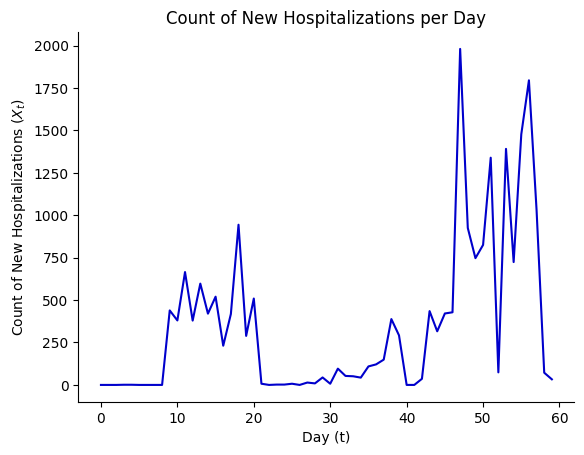

In [86]:
# Plot the number of hospitalizations per day.
days = np.arange(hosps_counts.size)

plt.title("Count of New Hospitalizations per Day")
plt.ylabel("Count of New Hospitalizations ($X_t$)")
plt.xlabel("Day (t)")
plt.plot(days, hosps_counts, color='#0000CC')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [87]:
# No TODOs here, just understand the steps of this function.
def fit_poisson_GLM(counts, days):
    """Estimates the parameters of the Poisson GLM.
    Fits a model of the form count ~ Poisson(exp(beta0 + beta1 * day)).
    
    Args:
      counts: Observed counts of hospitalizations per day (X_t).
      days: Days corresponding with the observed counts (t).
    
    Returns:
      beta0_MLE: maximum likelihood estimate of beta0.
      beta1_MLE: maximum likelihood estimate of beta1.
      beta1_lower: lower confidence bound on beta1.
      beta1_upper: upper confidence bound on beta1.
    """
    # Output distribution is Poisson. 
    # The link function is g(x) = log(x) by default with the Poisson family.
    glm = sm.GLM(counts, sm.add_constant(days), family=sm.families.Poisson())
    fitted_glm = glm.fit()
    summary = fitted_glm.summary()
    print(summary)
    
    # Get the maximum likelihood estimates of beta0 and beta1.
    beta0_MLE = fitted_glm.params[0]
    beta1_MLE = fitted_glm.params[1]
    
    # Compute the confidence interval on beta_1.
    confint = fitted_glm.conf_int(cols=(1,))[0]
    beta1_lower = confint[0]
    beta1_upper = confint[1]
    return beta0_MLE, beta1_MLE, beta1_lower, beta1_upper

In [88]:
# No TODOs here, just run this cell to estimate the parameters of the Poisson GLM.
beta0_MLE, beta1_MLE, beta1_lower, beta1_upper = fit_poisson_GLM(hosps_counts, days)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   60
Model:                            GLM   Df Residuals:                       58
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12686.
Date:                Wed, 15 Apr 2020   Deviance:                       25040.
Time:                        10:33:26   Pearson chi2:                 2.55e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5036      0.019    232.799      0.0

In [89]:
# TODO: convert estimate of beta0 to an estimate of Z0.
def convert_beta0_to_Z0(beta0):
    """Converts beta0 to initial true count Z0."""
    Z0 = np.e**beta0
    return Z0

Z0_MLE = convert_beta0_to_Z0(beta0_MLE)
print('Estimate of Z0: %s' % Z0_MLE)

Estimate of Z0: 90.34361538412227


In [90]:
# TODO: convert estimate of beta1 to an estimate of Z1.
def convert_beta1_to_r(beta1):
    """Converts beta1 to rate parameter r."""
    r = np.e**beta1 - 1
    return r

r_MLE = convert_beta1_to_r(beta1_MLE)
print('Estimate of r: %s' % r_MLE)

r_lower = convert_beta1_to_r(beta1_lower)
print('Lower confidence bound on r: %s' % r_lower)

r_upper = convert_beta1_to_r(beta1_upper)
print('Upper confidence bound on r: %s' % r_upper)

Estimate of r: 0.0396786022675335
Lower confidence bound on r: 0.038762858967818836
Upper confidence bound on r: 0.040595152860061434


In [91]:
# TODO: Using our estimates of Z0 and r, calculate the vector of all Zs.
def calculate_all_Zs(Z0, r, days):
    """Calculates Z_t for all time steps t given Z0 and r.
    
    Args:
      Z0: scalar initial count Z0.
      r: scalar growth rate of counts.
      days: array containing time steps t for which we want to calculate Z_t.
    
    Returns:
      Zs: array with the same length as days, where each entry in Zs is the
        calculated Z_t for the corresponding t in days.
    """

    Zs = np.array([Z0*(1+r)**t for t in days])
    return Zs

Zs_MLE = calculate_all_Zs(Z0_MLE, r_MLE, days)

For each estimated $Z_t$, we can also calculate a 95% confidence interval on the observed counts $X_t$, which are drawn from a Poisson distribution centered at $Z_t$.

In [92]:
# No TODOs here, just run this cell to calculate confidence bounds.

# Calculate upper and lower confidence bounds on Zs from r.
Zs_lower = calculate_all_Zs(Z0_MLE, r_lower, days)
Zs_upper = calculate_all_Zs(Z0_MLE, r_upper, days)

# Calculate upper and lower confidence bounds on Xs.
Xs_lower = sstats.poisson.ppf(0.025, Zs_lower)
Xs_upper = sstats.poisson.ppf(0.975, Zs_upper)

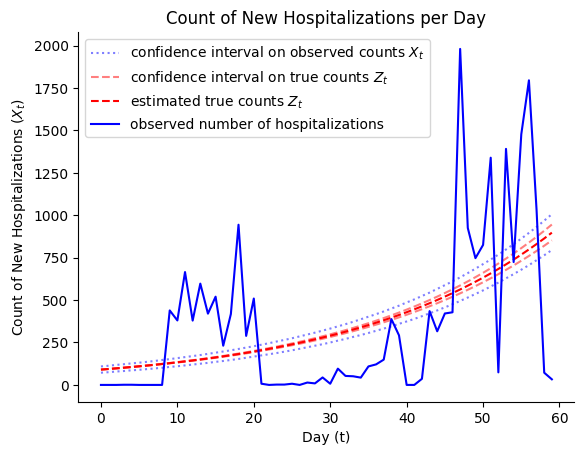

In [94]:
# Plot Zs and Xs. No TODOs here, just run this cell to plot results.

plt.plot(days, Xs_lower, 'b', alpha=0.5, label="confidence interval on observed counts $X_t$", linestyle='dotted')
plt.plot(days, Xs_upper, 'b', alpha=0.5, linestyle='dotted')

plt.plot(days, Zs_lower, 'r', alpha=0.5, label="confidence interval on true counts $Z_t$", linestyle='dashed')
plt.plot(days, Zs_MLE, 'r', label="estimated true counts $Z_t$", linestyle='dashed')
plt.plot(days, Zs_upper, 'r', alpha=0.5, linestyle='dashed')

plt.plot(days, hosps_counts, 'b', label="observed number of hospitalizations")
plt.title("Count of New Hospitalizations per Day")
plt.ylabel("Count of New Hospitalizations ($X_t$)")
plt.xlabel("Day (t)")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend();

But, there are many pitfalls for applying this exponential model to the growth in COVID-19 daily case counts. First, an exponential growth model implicitly assumes that there is unlimited population, since it does not account for saturation in the number of daily cases. Secondly, it might be the case that there are different subpopulations that grow at different rates. For instance, a denser region might have faster growth than a less dense region. A subpopulation with faster growth may quickly hit saturation in that subpopulation, and then the remaining growth in the overall number of hospitalizations would be due to the slower growth of the other subpopulation(s).

When this model is used to analyze real COVID-19 hospitalization data from New York, the resulting confidence intervals for the inferred growth rate are extremely over-confident, and do not
accurately capture the magnitude of the fluctuations actually observed in the count data. It turns
out that these phenomena arise largely due to the variance of the Poisson distribution being too
narrow. This phenomenon of count data having more variability than captured by a vanilla Poisson
distribution is called overdispersion.
To fix these issues, we can replace the Poisson distribution with a Negative Binomial distribution
which also models count data, but has a second parameter called the dispersion parameter which
allows it to model greater spread/variance relative to a Poisson distribution with the same mean

In [95]:
# No TODOs here, just understand the steps of this function.
def fit_nbinom_GLM(counts, days, alpha=0.15):
    """Estimates the parameters of the Poisson GLM.
    Fits a model of the form count ~ NBinom(exp(beta0 + beta1 * day), alpha).
    
    Args:
      counts: Observed counts of hospitalizations per day (X_t).
      days: Days corresponding with the observed counts (t).
      alpha: dispersion paramter for the negative binomial. 
        We fix this to 0.15 by default for this example.
    
    Returns:
      beta0_MLE: maximum likelihood estimate of beta0.
      beta1_MLE: maximum likelihood estimate of beta1.
      beta1_lower: lower confidence bound on beta1.
      beta1_upper: upper confidence bound on beta1.
    """
    # Output distribution is NegativeBinomial. 
    # The link function is g(x) = log(x) by default with the NegativeBinomial family.
    glm = sm.GLM(counts, sm.add_constant(days), family=sm.families.NegativeBinomial(alpha=alpha))
    fitted_glm = glm.fit()
    summary = fitted_glm.summary()
    print(summary)
    
    # Get the maximum likelihood estimates of beta0 and beta1.
    beta0_MLE = fitted_glm.params[0]
    beta1_MLE = fitted_glm.params[1]
    
    # Compute the confidence interval on beta_1.
    confint = fitted_glm.conf_int(cols=(1,))[0]
    beta1_lower = confint[0]
    beta1_upper = confint[1]
    return beta0_MLE, beta1_MLE, beta1_lower, beta1_upper

In [96]:
# No TODOs here, just run this cell to estimate the parameters of the Poisson GLM.
beta0_MLE, beta1_MLE, beta1_lower, beta1_upper = fit_nbinom_GLM(hosps_counts, days)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   60
Model:                            GLM   Df Residuals:                       58
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -801.16
Date:                Wed, 15 Apr 2020   Deviance:                       1108.6
Time:                        10:35:48   Pearson chi2:                     590.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6692      0.101     46.305      0.0

In [97]:
# No TODOs here, we can reuse the same functions we wrote in part A for this conversion.
Z0_MLE = convert_beta0_to_Z0(beta0_MLE)
print('Estimate of Z0: %s' % Z0_MLE)

Estimate of Z0: 106.61733289154807


In [98]:
# No TODOs here, we can reuse the same functions we wrote in part A for this conversion.
r_MLE = convert_beta1_to_r(beta1_MLE)
print('Estimate of r: %s' % r_MLE)

r_lower = convert_beta1_to_r(beta1_lower)
print('Lower confidence bound on r: %s' % r_lower)

r_upper = convert_beta1_to_r(beta1_upper)
print('Upper confidence bound on r: %s' % r_upper)

Estimate of r: 0.03487943798181892
Lower confidence bound on r: 0.028952556994496614
Upper confidence bound on r: 0.04084045846177298


In [99]:
# No TODOs here, we can reuse the same functions we wrote in part A.
Zs_MLE = calculate_all_Zs(Z0_MLE, r_MLE, days)

In [100]:
# No TODOs here, just run this cell to calculate confidence bounds.

# Calculate upper and lower confidence bounds on Zs from r.
Zs_lower = calculate_all_Zs(Z0_MLE, r_lower, days)
Zs_upper = calculate_all_Zs(Z0_MLE, r_upper, days)

# Calculate upper and lower confidence bounds on Xs.
# These functions convert the mean Z and dispersion alpha parameter into 
# the n and p paramters under a different parameterization of the 
# negative binomial distribution family. 
alpha = 0.15
def n():
    return 1.0/alpha
def p(mu):
    return n() / (n() + mu)
Xs_lower = sstats.nbinom.ppf(0.025, n(), p(Zs_lower))
Xs_upper = sstats.nbinom.ppf(0.975, n(), p(Zs_upper))

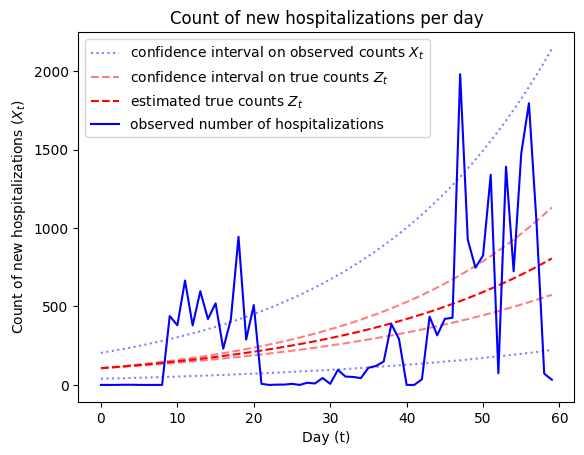

In [102]:
# Plot Zs and Xs. No TODOs here, just run this cell to plot results.

plt.plot(days, Xs_lower, 'b', alpha=0.5, label="confidence interval on observed counts $X_t$", linestyle='dotted')
plt.plot(days, Xs_upper, 'b', alpha=0.5, linestyle='dotted')

plt.plot(days, Zs_lower, 'r', alpha=0.5, label="confidence interval on true counts $Z_t$", linestyle='dashed')
plt.plot(days, Zs_MLE, 'r', label="estimated true counts $Z_t$", linestyle='dashed')
plt.plot(days, Zs_upper, 'r', alpha=0.5, linestyle='dashed')

plt.plot(days, hosps_counts, 'b', label="observed number of hospitalizations")
plt.title("Count of new hospitalizations per day")
plt.ylabel("Count of new hospitalizations ($X_t$)")
plt.xlabel("Day (t)")
plt.legend();

Even after using the Negative Binomial distribution to improve our model, we need to be careful
about how we interpret our results. Can we actually use this model to understand whether the
growth rate of COVID-19 is leveling off? Some factors to be wary of in interpreting our results
include:
            
1. The number of confirmed COVID-19 cases is confounded by underreporting (most infected people do not get tested) and rapid increase in testing capabilities (the total number of people tested increases).

2. An exponential growth model implicitly assumes that there is unlimited hospital capacity,
since it does not account for saturation in the number of hospitalizations. It also does not incorporate death in the population.

3. All types of COVID-19 data (confirmed cases, hospitalizations, etc.) come on a time lag (which itself is likely stochastic).

Combining all of these factors, even with good modeling techniques it is nearly impossible to determine whether policies like shelter-in-place mandates are having an effect on the underlying growth
rate until after-the-fact. 

Generalized Linear Models, combined with design choices natural for a specific domain are very powerful. Today we have seen how hospitals can leverage these insights to help predict hospital needs in the event of a disease outbreak. We have also seen how we can leverage data-driven tools to not only complement our decisions, but how to interpret them with caution. Thank you for reading 

In [ ]:
References:
    
    https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/poisson-distribution
        
    https://www.ijidonline.com/article/S1201-9712(20)30117-X/pdf
        
    https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30260-9/fulltext